# Reinforcement Learning für Autonomes Fahren - Highway Agent

## 1. Imports

In [ ]:
import gymnasium as gym
import highway_env
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from IPython import display
from moviepy import ImageSequenceClip
from IPython.display import Image

## 2. Hyperparameters

In [ ]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 256
GAMMA = 0.99
LR = 1e-4
TAU = 1e-3 
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995 

# Schauen, ob CUDA verfügbar ist und das Gerät entsprechend setzen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 3. Replay Buffer
Speichert die Erfahrungen des Agenten und ermöglicht das zufällige Sampeln von Batches.

In [ ]:
Experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    # Fügt eine Erfahrung zum Replay Buffer hinzu
    def add(self, state, action, reward, next_state, done):
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)

    # Entnimmt eine zufällige Stichprobe von Erfahrungen aus dem Replay Buffer
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.tensor(np.vstack([e.state for e in experiences]), dtype=torch.float32).to(device)
        actions = torch.tensor(np.vstack([e.action for e in experiences]), dtype=torch.int64).to(device)
        rewards = torch.tensor(np.vstack([e.reward for e in experiences]), dtype=torch.float32).to(device)
        next_states = torch.tensor(np.vstack([e.next_state for e in experiences]), dtype=torch.float32).to(device)
        dones = torch.tensor(np.vstack([e.done for e in experiences]).astype(np.uint8), dtype=torch.float32).to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

## 4. Q-Network (Neuronales Netz)
Ein MLP welches aus einem Zustand die Q-Werte für alle Aktionen schätzt

In [ ]:
class QNetwork(nn.Module):
    # Initialisiert das Q-Netzwerk mit den gegebenen Parametern
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, action_size)

    # Forward Layer für das Q-Netzwerk
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

## 5. DDQN-Agent
Der Agent, der mit der Umgebung interagiert und lernt

In [ ]:
class DDQNAgent:
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)

    # Initialisiert die Q-Netzwerkgewichte
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    # Wählt eine Aktion basierend auf dem aktuellen Zustand 
    def act(self, state, eps=0.):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    # Aktualisiert die Gewichte des Q-Netzwerks basierend auf einer Stichprobe
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        best_actions_next = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
        Q_targets_next = self.qnetwork_target(next_states).gather(1, best_actions_next)

        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.smooth_l1_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    # Soft Update" der Gewichte des Ziel-Netzwerks 
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


## 6. Training des Agenten
Hier startet die Haupt-Trainingsschleife

In [ ]:
# Erstellung des Gym Environments
env = gym.make('highway-v0', render_mode='rgb_array')
env.unwrapped.configure({
    "observation": {"type": "Kinematics"},
    "action": {"type": "DiscreteMetaAction"},
    "simulation_frequency": 15,
    "policy_frequency": 5
})

state, _ = env.reset()
state_size = state.flatten().shape[0]
action_size = env.action_space.n

agent = DDQNAgent(state_size=state_size, action_size=action_size, seed=0)

# Training des DDQN-Agenten
n_episodes = 2000
scores = []
scores_window = deque(maxlen=100)
eps = EPS_START

# Training Schleife
for i_episode in range(1, n_episodes + 1):
    state, _ = env.reset()
    state = state.flatten()
    score = 0
    done = False

    while not done:
        action = agent.act(state, eps)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = next_state.flatten()

        # Belohnung shaping
        shaped_reward = reward + 0.1 * next_state[3]
        shaped_reward = np.clip(shaped_reward, -1.0, 1.0)

        agent.step(state, action, shaped_reward, next_state, done)
        state = next_state
        score += reward

    scores_window.append(score)
    scores.append(score)
    eps = max(EPS_END, EPS_DECAY * eps)

    print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")
    if i_episode % 100 == 0:
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')

Episode 100	Average Score: 30.95
Episode 100	Average Score: 30.95
Episode 200	Average Score: 32.83
Episode 200	Average Score: 32.83
Episode 300	Average Score: 38.46
Episode 300	Average Score: 38.46
Episode 400	Average Score: 56.78
Episode 400	Average Score: 56.78
Episode 500	Average Score: 66.90
Episode 500	Average Score: 66.90
Episode 600	Average Score: 70.83
Episode 600	Average Score: 70.83
Episode 700	Average Score: 83.93
Episode 700	Average Score: 83.93
Episode 800	Average Score: 73.20
Episode 800	Average Score: 73.20
Episode 900	Average Score: 77.73
Episode 900	Average Score: 77.73
Episode 1000	Average Score: 84.28
Episode 1000	Average Score: 84.28
Episode 1100	Average Score: 91.45
Episode 1100	Average Score: 91.45
Episode 1200	Average Score: 80.51
Episode 1200	Average Score: 80.51
Episode 1300	Average Score: 85.24
Episode 1300	Average Score: 85.24
Episode 1400	Average Score: 97.97
Episode 1400	Average Score: 97.97
Episode 1500	Average Score: 89.65
Episode 1500	Average Score: 89.6

## 7. Visualisierung des Trainingsverlaufs

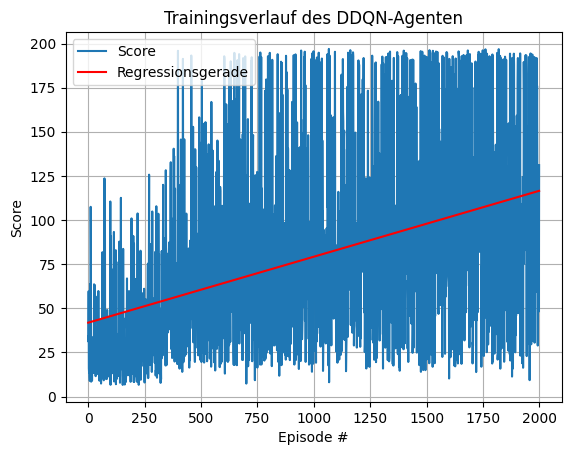

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Score')

# Regressionsgerade berechnen
x = np.arange(len(scores))
y = np.array(scores)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red', label='Regressionsgerade')

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Trainingsverlauf des DDQN-Agenten')
plt.grid()
plt.legend()
plt.show()

## 8. Evaluation und Visualisierung des trainierten Agenten
Ausführen des trainierten Agenten und GIF Darstellung

In [ ]:
# Erstellen der Evaluierungsumgebung
eval_env = gym.make('highway-v0', render_mode='rgb_array')
eval_env.unwrapped.configure({
    "observation": {"type": "Kinematics"},
    "action": {"type": "DiscreteMetaAction"},
    "simulation_frequency": 15,
    "policy_frequency": 5
})

# Durchführung der Evaluation und speichern der Frames
frames = []
for _ in range(3):
    state, _ = eval_env.reset()
    state = state.flatten()
    done = False
    while not done:
        frames.append(eval_env.render())
        action = agent.act(state, eps=0.0)
        next_state, reward, terminated, truncated, _ = eval_env.step(action)
        done = terminated or truncated
        state = next_state.flatten()

eval_env.close()

# Erstellen des GIFs aus den Frames
clip = ImageSequenceClip(frames, fps=15)
clip.write_gif('trained_agent.gif', fps=15)

print("GIF wurde als 'trained_agent.gif' gespeichert.")
Image(url='trained_agent.gif')

MoviePy - Building file trained_agent.gif with imageio.


GIF wurde als 'trained_agent.gif' gespeichert.
